In [3]:
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

In [4]:
with open ("weatherAPI.txt", "r") as file:
    apiKey= file.read().strip()

city= input("Enter city name: ")

baseURL = "https://api.openweathermap.org/data/2.5/forecast"


url = f"{baseURL}?q={city}&appid={apiKey}"
response = requests.get(url)
data=response.json() #data is a dictionary given to us by the API
print(city, ": ")


Enter city name:  London


London : 


In [35]:
#Extract relevent data into an organised way in the weatherData variable
weatherData = [
    {
        'Date': item['dt_txt'],
        'Temperature': item['main']['temp'],
        'Humidity': item['main']['humidity'],
        'WindSpeed': item['wind']['speed']
    }
    for item in data['list']   #data['list'] is an unorganised list of dictionaries, we acess every dicitionary(named item in for loop) and we organise it
] #weather data is now a structured list of dictionaries.

In [43]:
df= pd.DataFrame(weatherData) #weather data now in tabulr form
df.shape

(40, 4)

In [15]:
# Create lagged features for Temperature, Humidity, and WindSpeed
df['Temperature_Lag1'] = df['Temperature'].shift(1)
df['Humidity_Lag1'] = df['Humidity'].shift(1)
df['WindSpeed_Lag1'] = df['WindSpeed'].shift(1)

In [17]:
df.head() #debug

,Date,Temperature,Humidity,WindSpeed,Temperature_Lag1,Humidity_Lag1,WindSpeed_Lag1
0,2025-01-13 21:00:00,277.04,85,3.19,NaN,NaN,NaN
1,2025-01-14 00:00:00,277.16,81,3.13,277.04,85.0,3.19
2,2025-01-14 03:00:00,277.10,81,3.05,277.16,81.0,3.13
3,2025-01-14 06:00:00,277.06,83,3.04,277.10,81.0,3.05
4,2025-01-14 09:00:00,277.02,85,2.38,277.06,83.0,3.04


In [19]:
# Drop rows with NaN values (first row will have NaN due to lagged features)
df = df.dropna() #rows with NaN are removed


In [21]:
df.head() #debug

,Date,Temperature,Humidity,WindSpeed,Temperature_Lag1,Humidity_Lag1,WindSpeed_Lag1
1,2025-01-14 00:00:00,277.16,81,3.13,277.04,85.0,3.19
2,2025-01-14 03:00:00,277.10,81,3.05,277.16,81.0,3.13
3,2025-01-14 06:00:00,277.06,83,3.04,277.10,81.0,3.05
4,2025-01-14 09:00:00,277.02,85,2.38,277.06,83.0,3.04
5,2025-01-14 12:00:00,279.99,78,2.53,277.02,85.0,2.38


In [23]:
#context for this cell: The resulting outcomes for tomorrow's weather highly depends on the weather of today, yesterday, day before yesterday etc
# hence we make the lag colums. temp_lag has the temperature for the day before while its respective temp has today's temperature
# as our model needs to study previous data, we will assign the lag columns to X, and the original(or next) columns to y



# Define X (features) and y (targets)
X = df[['Temperature_Lag1', 'Humidity_Lag1', 'WindSpeed_Lag1']] #lag columns assigned to X
y = df[['Temperature', 'Humidity', 'WindSpeed']] 

# Check the resulting DataFrame
print("Printing X")
print(X.head())
print("Printing y")
print(y.head())

Printing X
   Temperature_Lag1  Humidity_Lag1  WindSpeed_Lag1
1            277.04           85.0            3.19
2            277.16           81.0            3.13
3            277.10           81.0            3.05
4            277.06           83.0            3.04
5            277.02           85.0            2.38
Printing y
   Temperature  Humidity  WindSpeed
1       277.16        81       3.13
2       277.10        81       3.05
3       277.06        83       3.04
4       277.02        85       2.38
5       279.99        78       2.53


In [25]:
Xtrain, Xtest, yTrain, yTest = train_test_split(X, y, test_size=0.2)

In [35]:
model = LinearRegression()
model.fit(Xtrain, yTrain)
 

LinearRegression()

In [37]:
testPred = model.predict(Xtest)
score = mean_absolute_error(testPred, yTest)
print(score) #the difference between prediction and test. the lower the better

1.610885602501548


In [39]:
yPredDf = pd.DataFrame(testPred, columns=['Temp Pred', 'Humidity Pred', 'Wind Speed Pred'])
yTestDf = yTest.reset_index(drop=True) # if yTest was originally a Series or indexed in a way that doesn’t align with the DataFrame, reset_index(drop=True) ensures that the indices align with those of the predictions (y_pred).
comparisonDf = pd.concat([yTestDf, yPredDf], axis=1) #concatenates the above two dataframes for easier comparision

print(comparisonDf)

   Temperature  Humidity  WindSpeed   Temp Pred  Humidity Pred  \
0       281.36        91       1.03  279.723435      94.372458   
1       276.46        86       1.25  277.113776      83.269619   
2       280.98        92       1.55  280.606439      93.185227   
3       278.91        68       1.56  277.443704      74.461335   
4       281.73        91       1.45  280.680513      93.148350   
5       278.97        97       1.72  280.148583      93.260997   
6       276.82        81       1.16  277.929478      82.732489   
7       276.36        89       1.14  277.389240      83.520744   

   Wind Speed Pred  
0         1.333436  
1         1.353782  
2         0.107117  
3         1.624438  
4         0.856592  
5         1.371960  
6         1.448442  
7         1.311341  


In [57]:
#making predictions for the next 5 days
futureInput = X.iloc[-1:]

futurePrediction = []

for _ in range(5):
    futureOutput = model.predict(futureInput)
    futurePrediction.append(futureOutput[0])

    futureInput =pd.DataFrame( 
        [[
        futureOutput[0][0],
        futureOutput[0][1],
        futureOutput[0][2]
        ]],
        columns = X.columns
    )

In [61]:
futurePredictionDF = pd.DataFrame(futurePrediction, columns = ['Temperature', 'Humidity', 'WindSpeed'])

In [63]:
print(futurePredictionDF)

   Temperature   Humidity  WindSpeed
0   277.877876  75.956779   1.418952
1   277.545831  78.624556   1.414901
2   277.452418  79.575045   1.448741
3   277.443131  79.983106   1.488409
4   277.465357  80.230794   1.524034


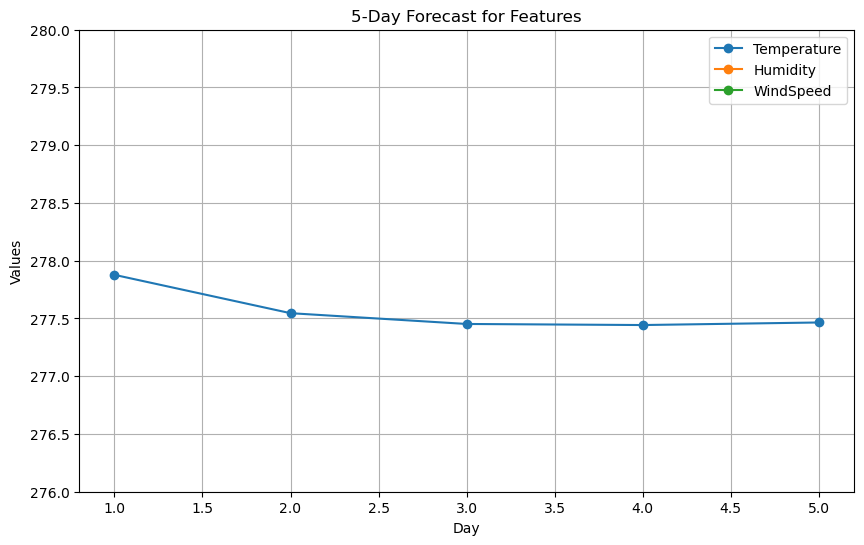

In [87]:
import matplotlib.pyplot as plt

# Add a column for days (1 to 5)
futurePredictionDF['Day'] = range(1, 6)

# Plot the features. makes a graph 10 inches widr and 6 inches tall
plt.figure(figsize=(10, 6))

plt.plot(futurePredictionDF['Day'], futurePredictionDF['Temperature'], label='Temperature', marker='o')
plt.plot(futurePredictionDF['Day'], futurePredictionDF['Humidity'], label='Humidity', marker='o')
plt.plot(futurePredictionDF['Day'], futurePredictionDF['WindSpeed'], label='WindSpeed', marker='o')

# Add titles and labels
plt.title('5-Day Forecast for Features')
plt.xlabel('Day')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# plt.ylim(276, 280) to adjust the scale of graph
# Display the plot
plt.show()
